# Pytorch part 3 - training an CNN
> This notebook will reuse functions from part 2 in order to train an CNN and then together we will see how to interpret the training's result. 
- toc: true 
- badges: true
- comments: true
- categories: [self-taught, tutorial]
- image: images/pytorch_ava.png

In this part, we will go through a basic pipeline of training and debugging neural network which contains 4 main steps:
1. Prepare the data for training
2. Build the model
3. Train the model
4. Analyze the model's results

In reality there are 2 very improtant steps that we are ignoring here:
- Data collection and labeling: this step comes before step 1 and is the most tricky and time consuming. 
- Deployment and testing: after finishing training, we need to deploy it to production. We will try to cover this step later. 
To be simple and pytorch oritented, we will use the same dataset like part 2, `FASHION MNIST`, but now we will require some helps from `torchvision` package. 

So now, let's get started!

## Data and Data processing
1. **Prepare the data for training** - *we are here*
2. Build the model
3. Train the model
4. Analyze the model's results

Briefly remind, the Fashion-MNIST dataset which was designed to mirror the original MNIST dataset as closely as possible while introducing higher difficulty in training due to simply having more complex data than hand written images. 

The dataset has the following ten classes of fashion items:

| Index | 0           | 1       | 2        | 3     | 4    | 5      | 6     | 7       | 8   | 9          |
|-------|-------------|---------|----------|-------|------|--------|-------|---------|-----|------------|
| Label | T-shirt/top | Trouser | Pullover | Dress | Coat | Sandal | Shirt | Sneaker | Bag | Ankle boot |

A sample of the items look like this:  

![sample_fashition_mnist](data/sample_fashion_mnist.png)

Firstly we need to import all the necessary packages. 

In [1]:
# import common Pytorch packages
import torch   
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F

import torchvision 
import torchvision.transforms as transforms 

# import other common packages used for data science
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import pdb # python debugger 

torch.set_printoptions(linewidth=120) # set print options for pytorch printe statements

We'll follow ETL process using torchvision:
- Extract: Get the Fashion-MNIST image data from the source.
- Transform: Put our data into tensor form.
- Load: Put our data into an object to make it easily accessible.

For these purposes, PyTorch provides us with two classes:
- `torch.utils.data.Dataset`: an abstract class for representing a dataset. An abstract class is a Python class that has methods we must implement, in our case are `__getitem__` and `__len__`. In order to create a custom dataset, we need to subclass the `Dataset` class and override `__len__`, that provides the size of the dataset, and `__getitem__`, supporting integer indexing in range from 0 to len(self) exclusive. Upon doing this, our new subclass can then be passed to the a PyTorch DataLoader object. 
- `torch.utils.data.DataLoader`: wraps a dataset and provides access to the underlying data.

The fashion-MNIST dataset that comes built-in with the `torchvision` package, so we won’t have to do the steps mentioned above for creatign a new dataset. Just know that the Fashion-MNIST built-in dataset class is doing this behind the scenes.  
When we run the code below for the first time, the Fashion-MNIST dataset will be downloaded locally. Subsequent calls check for the data before downloading it. Thus, we don't have to worry about double downloads or repeated network calls.

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data',                            # The location on disk where the data is located.
    train=True,                               # If the dataset is the training set
    download=True,                            # If the data should be downloaded.
    transform=transforms.Compose([            # A composition of transformations performed on dataset elements.
        transforms.ToTensor()
    ])
)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


Wrap the dataset into dataloader and load our first batch of sammple.

In [6]:
train_dl = torch.utils.data.DataLoader(train_set, 
                                       batch_size=4, 
                                       shuffle=True) # the batch will be different each time a call next occurs.
images, labels = next(iter(train_dl))
images.shape, labels.shape

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

The size of each dimention in the image tensor is defined as `(batch size, number of color channels, image height, image width)`.  
The labels tensor has a single axis with a shape of 4, which corresponds to the 4 images inside our batch. One label for each image.

So now, we have our desired dataset and dataloader in order to feed into the neural net. We can play around with the dataset to better understand it.

In [5]:
# the number of samples in our dataset
len(train_set)

60000

In [6]:
# label of all 6000 images in train_set
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [40]:
# classes to predict 
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
# number of samples per class
train_set.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

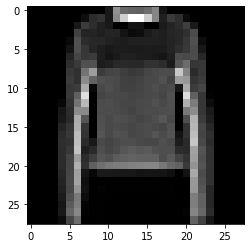

In [41]:
# take a look on a single item
ys[0].item()
plt.imshow(xs[0].squeeze(), cmap="gray")

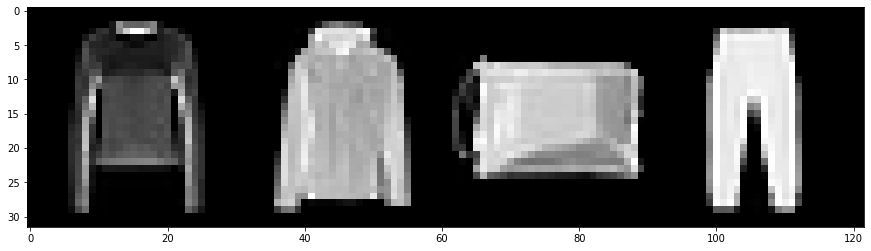

In [42]:
# take a look on a batch
grid = torchvision.utils.make_grid(xs, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))
# plt.imshow(np.transpose(grid, (1,2,0)))

## Neural Net design with Pytorch
1. Prepare the data for training 
2. **Build the model** -         *we are here*
3. Train the model
4. Analyze the model's results

We’re building a CNN, so the two types of layers we'll use are linear layers and convolutional layers.   
In order to build model using Pytorch, we have 3 essential steps:
1. Create a neural network class that extends the nn.Module base class.
    - `torch.nn` is PyTorch’s neural network (nn) library which contains the primary components to construct network's layers.
    - Within the `torch.nn` package, there is a class called `Module`, and it is the base class for all of neural network modules which includes layers. All of the layers in PyTorch need to extend this base class in order to inherit all of PyTorch’s built-in functionality within the nn.Module class.
    - For each layer, there are two primary items encapsulated inside, a `forward` function definition and a `weight tensor` which is updated as the network learns during the training process. PyTorch's neural network `module class` keeps track of the weight tensors inside each layer as `learnable parameters` of our network. Take a look at `Random topics` section for more detail info about network parameters.
2. Define the network's layers as class attributes in the class constructor.
    - We have two convolutional layers, `self.conv1` and `self.conv2`, and three linear layers, `self.fc1`, `self.fc2`, `self.out`.
    - We used the abbreviation `fc` in `fc1` and `fc2` because linear layers are also called fully connected layers or dense layer. So `linear` = `dense` = `fully connected.`
3. Define the network's forward method using the network's layer attributes as well nn.functional API operations.
    - Every Pytorch `nn.Module` has a `forward()` method and so when we are building layers and networks, we must provide an implementation of the forward() method. The forward method is the actual transformation.
    - The tensor input is passed forward though each layer transformation until the tensor reaches the output layer. The composition of all the individual layer forward passes defines the overall forward pass transformation for the network. The goal of the overall transformation is to transform or map the input to the correct prediction output class, and during the training process, the layer weights (data) are updated in such a way that cause the mapping to adjust to make the output closer to the correct prediction.
    - When we implement the forward() method of our nn.Module subclass, we will typically use functions from the `nn.functional` package. This package provides us with many neural network operations that we can use for building layers. In fact, many of the nn.Module layer classes use nn.functional functions to perform their operations.

In [93]:
#collapse-show
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):    # Extend the nn.Module base class.
    def __init__(self):      # Define layers as class attributes using pre-built layers from torch.nn
        super().__init__()   # Extend the nn.Module base class.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # linear = dense = fc
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, x):    # Implement the forward() using network’s layer attributes and method from the nn.functional
        # (1) input layer
        print(f"tensor shape before input layer 1: {x.shape}")
        x = x 
        
        # (2) hidden conv layer
        print(f"tensor shape before conv layer 2: {x.shape}")
        x = self.conv1(x)
        print(f"tensor shape after conv operation: {x.shape}")
        x = F.relu(x)
        print(f"tensor shape after relu operation: {x.shape}")
        x = F.max_pool2d(x, kernel_size=2, stride=2) 
        print(f"tensor shape after max_pool2d operation: {x.shape}")
        
        # (3) hidden conv layer
        print(f"tensor shape before conv layer 3: {x.shape}")
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2) 

        # (4) hidden linear layer
        print(f"tensor shape before linear layer 4: {x.shape}")
        x = x.flatten(start_dim=1) # x.reshape(-1, 12*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        
        # (5) hidden linear layer
        print(f"tensor shape before linear layer 5: {x.shape}")
        x = self.fc2(x)
        x = F.relu(x)
        
        # (6) output layer
        print(f"tensor shape before output layer 6: {x.shape}")
        x = self.out(x)
#         x = F.softmax(x, dim=1)
        print(f"tensor shape after output layer 6: {x.shape}")

        return x

Now let's feed a batch of images to our model and get its output.

In [94]:
model = Network()
model

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [95]:
preds = model(images)
print(f"\nprediction tensor:\n{preds}")

tensor shape before input layer 1: torch.Size([4, 1, 28, 28])
tensor shape before conv layer 2: torch.Size([4, 1, 28, 28])
tensor shape after conv operation: torch.Size([4, 6, 24, 24])
tensor shape after relu operation: torch.Size([4, 6, 24, 24])
tensor shape after max_pool2d operation: torch.Size([4, 6, 12, 12])
tensor shape before conv layer 3: torch.Size([4, 6, 12, 12])
tensor shape before linear layer 4: torch.Size([4, 12, 4, 4])
tensor shape before linear layer 5: torch.Size([4, 120])
tensor shape before output layer 6: torch.Size([4, 60])
tensor shape after output layer 6: torch.Size([4, 10])

prediction tensor:
tensor([[ 0.1019,  0.0483,  0.0173,  0.0009, -0.0897,  0.0271,  0.0504,  0.0375, -0.0684,  0.0975],
        [ 0.1034,  0.0475,  0.0144,  0.0004, -0.0898,  0.0264,  0.0559,  0.0403, -0.0646,  0.0972],
        [ 0.1083,  0.0468,  0.0131,  0.0014, -0.0858,  0.0244,  0.0559,  0.0406, -0.0670,  0.0975],
        [ 0.1042,  0.0481,  0.0165, -0.0039, -0.0911,  0.0290,  0.0476,  0

One thing to point out that Pytorch neural network modules are `callable Python objects` - we called the `Network` instance as if it were a function.
What makes this possible is that PyTorch module classes implement a special Python function called `__call__()`. which will be invoked anytime the object instance is called. After the object instance is called, the `__call__()` method is invoked under the hood, and the `__call__()` in turn invokes the `forward()` method. Instead of calling the `forward()` method directly, we call the object instance. This applies to all PyTorch neural network modules, namely, networks and layers.

In order to access the model parameters, we can use `parameters()` or `named_parameters()` method.   
To keep track of all the weight tensors inside the network. PyTorch has a special class called `Parameter`. The weight tensor inside every layer is an instance of this `Parameter` class. PyTorch’s `nn.Module` class is basically looking for any attributes whose values are instances of the `Parameter` class, and when it finds an instance of the parameter class, it keeps track of it.


In [74]:
for param in model.parameters():
    print(param.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([12, 6, 5, 5])
torch.Size([12])
torch.Size([120, 192])
torch.Size([120])
torch.Size([60, 120])
torch.Size([60])
torch.Size([10, 60])
torch.Size([10])


In [73]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

conv1.weight: torch.Size([6, 1, 5, 5])
conv1.bias: torch.Size([6])
conv2.weight: torch.Size([12, 6, 5, 5])
conv2.bias: torch.Size([12])
fc1.weight: torch.Size([120, 192])
fc1.bias: torch.Size([120])
fc2.weight: torch.Size([60, 120])
fc2.bias: torch.Size([60])
out.weight: torch.Size([10, 60])
out.bias: torch.Size([10])


Ok so now, we will go through each layer in order to inspect, debug it. One basic technique is to inspect tensor shape at each layer. Remember, the shape of a tensor really encodes all the information we need to know about the tensor.

### Input layer 1
`tensor shape before input layer 1: torch.Size([1, 1, 28, 28])`  
`tensor shape before conv layer 2: torch.Size([1, 1, 28, 28])`

This value in each of these dimensions represent the following values: `(batch size, color channels, height, width)`.  
Since the input layer is just the identity function, the output shape doesn’t change.

### Hidden conv layer 2
`tensor shape after relu operation: torch.Size([1, 6, 24, 24])`  
`tensor shape after max_pool2d operation: torch.Size([1, 6, 12, 12])`
![](data/conv.gif)


Our convolution layer includes 3 operations: `convolution`, `relu` and `max_pooling 2d`. Now we will go through each operation. Be attention that the `batch_size` is fixed as we move though the entire forward pass. 
#### `Convolution Operation`:   
`tensor shape before conv layer 2: torch.Size([1, 1, 28, 28])`  
`tensor shape after conv operation: torch.Size([1, 6, 24, 24])`  

In [77]:
model.conv1

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))

In [76]:
model.conv1.weight.shape, model.conv1.bias.shape

(torch.Size([6, 1, 5, 5]), torch.Size([6]))

Some keynotes about this operation:
- This operation convolves the input tensor using 6 randomly initialized 5x5 layers, also known as `filters` or `kernels`, to produce 6 output channels. The stride tells the conv layer how far the filter should slide after each operation in the overall convolution. 
- explain parameters of this operation:
    - kernel_size: Sets the filter size. The words kernel and filter are interchangeable.
    - out_channels: Sets the number of filters. One filter produces one output channel.
    - out_features: Sets the size of the output tensor.
- The `weight tensor` is a rank-4 tensor and reflects `(nr of filters, depth, height, width)`.   
- `The filters have depth that accounts for the input channels`.  
- The parameter `out_channels` defined in `self.conv1` determines how many filters will be created. However, we dont actually have 6 distinct tensors but `all tensors are represented using a single weight tensor`.  
- After convolution, the output channels are generated which is also called `feature maps`. This is due to the fact that the pattern detection that emerges as the weights are updated represent features like edges and other more sophisticated patterns.
- One pattern that shows up quite often is that we increase our `out_channels` as we add additional conv layers, and after we switch to linear layers we shrink our out_features as we filter down to our number of output classes.

#### `Relu operation`: 

This operation maps all negative values to 0. This means that all the values in the tensor are now positive. This function is pure operation and does not have weights. That's why we call them directly from the `nn.functional`.

#### `Max pooling operation`: 

This operation extracts the max value from each 2x2 section of the fix feature maps that were created by the convolutions.  
The same as `relu`, this operation does not have weight and is called directly from `nn.functional`. Sometimes we may see pooling operations referred to as pooling layers. However, what makes a layer distinct from an operation is that layers have weights. Since pooling operations and activation functions do not have weights, we will refer to them as operations and view them as being added to the collection of layer operations.   

Let's have a look at the formula for computing the output size of the tensor after performing convolutional and pooling operations.   
Given $n_{h} \times n_{w}$ input, $f_{h} \times f_{w}$ filter, padding $p$ and stride $s$.
The height, width of the output size $O_{h}$, $O_{w}$ is defined by this formular:

\begin{equation}
O_{h}=\frac{n_{h}-f_{h}+2 p}{s}+1;    
O_{w}=\frac{n_{w}-f_{w}+2 p}{s}+1
\end{equation}



    

### Hidden conv layer 3
`tensor shape before conv layer 3: torch.Size([1, 6, 12, 12])`  
`tensor shape before linear layer 4: torch.Size([1, 12, 4, 4])`

In [78]:
model.conv2

Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))

In [79]:
model.conv2.weight.shape, model.conv2.bias.shape

(torch.Size([12, 6, 5, 5]), torch.Size([12]))

This layer transforms the tensor in the same was as `self.conv1` and reduces the height and width dimensions further. However, each filter now has a depth of 6 which come from the 6 output channels from the first convolution layer. 
The shape of the resulting output of `self.conv2` allows us to see why we reshape, also called `flattening`, the tensor using `12*4*4` before passing the tensor to the first linear layer, `self.fc1`. The resulting shape is `1x192`. The 1 in this case represents the batch size, and the 192 is the number of elements in the tensor that are now in the same dimension.

### linear layer 4, 5
`tensor shape before linear layer 4: torch.Size([1, 12, 4, 4])`  
`tensor shape before linear layer 5: torch.Size([1, 120])`  
`tensor shape before output layer 6: torch.Size([1, 60])`  
`tensor shape after output layer 6: torch.Size([1, 10])`

In [90]:
print(model.fc1)
model.fc1.weight.shape, model.fc1.bias.shape

Linear(in_features=192, out_features=120, bias=True)


(torch.Size([120, 192]), torch.Size([120]))

In [91]:
print(model.fc2)
model.fc2.weight.shape, model.fc2.bias.shape

Linear(in_features=120, out_features=60, bias=True)


(torch.Size([60, 120]), torch.Size([60]))

In [92]:
print(model.out)
model.out.weight.shape, model.out.bias.shape

Linear(in_features=60, out_features=10, bias=True)


(torch.Size([10, 60]), torch.Size([10]))

Now, we just have a series of linear layers followed by non-linear activation function until we reach the output layer.
`Linear layers` use matrix multiplication to transform their `in_features` to `out_features`. 
For example `self.fc1` has in_feature's shape (1, 192) and out_feature's shape (1, 120). Its `weight matrix` will have the shape of (120,192). In general, the weight matrix defines a linear function that maps a 1-dimensional tensor with 192 elements to a 1-dimensional tensor that has 120 elements. The weight matrix is auto generated with randomly initizalized weights when we create an instance of linear layer class.

Given $A$, $x$, $b$, $y$ are `Weight matrix tensor`, `Input tensor`, `Bias tensor` and `Output tensor`, respectively. Mathematical notation of the linear transformation is:
\begin{equation}
y=A x+b
\end{equation}




### output layer 6
`tensor shape before output layer 6: torch.Size([1, 60])`  
`tensor shape after output layer 6: torch.Size([1, 10])`

`prediction tensor:
tensor([[-0.0197,  0.1284, -0.1158, -0.0096, -0.0135,  0.0599, -0.0663,  0.0724, -0.0030, -0.0063],
        [-0.0270,  0.1266, -0.1168, -0.0085, -0.0073,  0.0600, -0.0675,  0.0805, -0.0065, -0.0103],
        [-0.0255,  0.1297, -0.1183, -0.0134, -0.0149,  0.0569, -0.0709,  0.0623, -0.0059, -0.0065],
        [-0.0316,  0.1310, -0.1178, -0.0057, -0.0064,  0.0585, -0.0710,  0.0796, -0.0054, -0.0063]],
       grad_fn=<AddmmBackward>)`

The prediction tensor has a shape of (4, 10) which reflects `(batch_size, number of prediction classes)`. The `number of prediction classes` is 10 because we have 10 classes, each number is the assigned value of the specific output class.  

Inside the network we usually use `relu()` as our non-linear activation function, but for the output layer, we use `softmax()`. The softmax function returns a positive probability for each of the prediction classes, and the probabilities sum to 1. However, in our case, we won't use `softmax()` because the loss function that we'll use, `F.cross_entropy()`, implicitly performs the `softmax()` operation on its input, so we'll just return the result of the last linear transformation. (save one operation at inference^^)

To check the predictions against the labels, we use the `argmax()` function to figure out which index contains the highest prediction value. Once we know which index has the highest prediction value, we can compare the index with the label to see if there is a match.


In [63]:
F.softmax(preds)

/Users/phucnsp/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.0976, 0.1131, 0.0886, 0.0986, 0.0982, 0.1057, 0.0931, 0.1070, 0.0992, 0.0989],
        [0.0969, 0.1130, 0.0886, 0.0987, 0.0988, 0.1057, 0.0930, 0.1079, 0.0989, 0.0985],
        [0.0973, 0.1137, 0.0887, 0.0985, 0.0984, 0.1057, 0.0930, 0.1063, 0.0993, 0.0992],
        [0.0964, 0.1134, 0.0885, 0.0989, 0.0989, 0.1055, 0.0927, 0.1078, 0.0990, 0.0989]], grad_fn=<SoftmaxBackward>)

In [67]:
pred_after_argmax = torch.argmax(F.softmax(preds), dim=1)
pred_after_argmax

/Users/phucnsp/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([1, 1, 1, 1])

Now we can compare the prediciton result against the label tensor by using `eq` operation which will do element-wise comparision between prediction tensor and label tensor. And then we will sum the correct prediction to see how many predictions are correct.  

In [69]:
pred_after_argmax.eq(labels).sum()

tensor(2)

## Training NN

We are now ready to begin the training process. The training process is an iterative process which including following steps:
1. **Get batch from the training set**.  
    - Since we have 60,000 samples in our training set, we will have 60,000 / 100 = 600 iterations. Something to notice, batch_size will directly impact to the number of times the weights updated. In our case, the weights will be updated 600 times by the end of each loop. So far, there is no rule-of-thump for selecting the value of batch size so we still need to do trial and error to figure out the best value.
    
2. **Pass batch to network.**

3. **Calculate the loss (difference between the predicted values and the true values).**
    - To be notice, the function `cross_entropy` has a parameter called `reduction` which has 3 option - `none, mean, sum`. By default, this variable is set to `mean` which will average the loss value by batch_size. `None` and `sum` means there is no reduction applied and the output will be summed, respectively.

4. **Calculate the gradient of the loss function w.r.t the network's weights.**
   - Before calculate the gradient, we need to zero out these gradients, by calling `optimizer.zero_grad()`, because after we call the loss.backward() method, the gradients will be calculated and added to the grad attributes of our network's parameters.  
   - Calculating the gradients is very easy using PyTorch. Since PyTorch has created a computation graph under the hood. As our tensor flowed forward through our network, all of the computations where added to the graph. The computation graph is then used by PyTorch to calculate the gradients of the loss function with respect to the network's weights.
   
5. **Update the weights using the gradients to reduce the loss.**
    - The gradients calculated from step 4 are used by the optimizer to update the respective weights. 
    
6. **Repeat steps 1-5 until one epoch is completed.**
7. **Repeat steps 1-6 for as many epochs required to reach the minimum loss.**

To create our optimizer, we use the `torch.optim` package that has many optimization algorithm implementations that we can use, for example: Adam. The model's parameters and learning rate are passed to the optimizer. `lr` tells optimizer how far to step in the direction of minimizing loss fct while `Parameters` provide Adam the ability to access gradients. 


In [6]:
model = Network()
train_dl = torch.utils.data.DataLoader(train_set, batch_size=100) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 
accuracy = lambda preds, lbs: (F.softmax(preds).argmax(dim=1) == lbs).sum().item()

for epoch in range(3):
    
    total_loss = 0
    total_acc = 0

    for batch in train_dl:                    
        images, labels = batch                # 1. Get batch from the training set.
        preds = model(images)                 # 2. Pass batch to network.
        loss = F.cross_entropy(preds, labels) # 3. Calculate the loss

        optimizer.zero_grad()            
        loss.backward()                       # 4. Calculate the gradient
        optimizer.step()                      # 5. Update the weights

        total_loss += loss.item()
        total_acc  += accuracy(preds, labels)
    
    nr_iters_per_epoch = len(train_dl)
    print(f"epoch:       {epoch} \navg_loss: {total_loss/nr_iters_per_epoch} \navg_acc : {total_acc/nr_iters_per_epoch}")
    

/Users/phucnsp/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


epoch:       0 
avg_loss: 0.6262958686550458 
avg_acc : 76.13
epoch:       1 
avg_loss: 0.4225387443850438 
avg_acc : 84.28333333333333
epoch:       2 
avg_loss: 0.37975253333648046 
avg_acc : 85.75166666666667


## Analyze the model's results

##### Analyse classification result using a Confusion Matrix 

The confusion matrix will show us which categories the model is predicting correctly and which categories the model is predicting incorrectly. For the incorrect predictions, this will show us which categories are confusing the model.

Now, if we compare the two tensors element-wise and count the number of predicted labels vs the target labels, the values inside the two tensors act as coordinates for our matrix. Let's stack these two tensors along the second dimension so we can have 60,000 ordered pairs.

In [81]:
len(train_set), len(train_set.targets)

(60000, 60000)

In [82]:
# Get predictions for the entire training set
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        imgs, lbs = batch
        
        preds = model(imgs)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(model, prediction_loader)
    
stacked = torch.stack(
(
    train_set.targets,
    train_preds.argmax(dim=1)
), dim=1)
stacked.shape

torch.Size([60000, 2])

In [83]:
# method 1: manually calculate confusion matrix
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl,pl] += 1
cmt

tensor([[5523,    1,   46,   59,   15,    2,  306,    0,   48,    0],
        [  36, 5829,    3,   77,   15,    0,   32,    0,    8,    0],
        [ 144,    6, 3704,   51, 1359,    3,  603,    0,  129,    1],
        [ 554,   26,    2, 5077,  189,    0,  135,    0,   15,    2],
        [  49,    3,   99,  161, 5298,    1,  316,    0,   72,    1],
        [  13,    0,    0,    0,    0, 5671,    0,  178,   81,   57],
        [1443,   10,  244,   75,  693,    0, 3414,    0,  121,    0],
        [   1,    0,    0,    0,    0,   38,    0, 5823,   19,  119],
        [  45,    0,    4,    8,   17,    1,   34,    4, 5884,    3],
        [   0,    0,    0,    0,    0,   23,    0,  261,    6, 5710]])

In [84]:
# method 2: use sklearn 

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

array([[5523,    1,   46,   59,   15,    2,  306,    0,   48,    0],
       [  36, 5829,    3,   77,   15,    0,   32,    0,    8,    0],
       [ 144,    6, 3704,   51, 1359,    3,  603,    0,  129,    1],
       [ 554,   26,    2, 5077,  189,    0,  135,    0,   15,    2],
       [  49,    3,   99,  161, 5298,    1,  316,    0,   72,    1],
       [  13,    0,    0,    0,    0, 5671,    0,  178,   81,   57],
       [1443,   10,  244,   75,  693,    0, 3414,    0,  121,    0],
       [   1,    0,    0,    0,    0,   38,    0, 5823,   19,  119],
       [  45,    0,    4,    8,   17,    1,   34,    4, 5884,    3],
       [   0,    0,    0,    0,    0,   23,    0,  261,    6, 5710]])

To nicely plot the confusion matrix, we can use below util function.


In [85]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5523    1   46   59   15    2  306    0   48    0]
 [  36 5829    3   77   15    0   32    0    8    0]
 [ 144    6 3704   51 1359    3  603    0  129    1]
 [ 554   26    2 5077  189    0  135    0   15    2]
 [  49    3   99  161 5298    1  316    0   72    1]
 [  13    0    0    0    0 5671    0  178   81   57]
 [1443   10  244   75  693    0 3414    0  121    0]
 [   1    0    0    0    0   38    0 5823   19  119]
 [  45    0    4    8   17    1   34    4 5884    3]
 [   0    0    0    0    0   23    0  261    6 5710]]


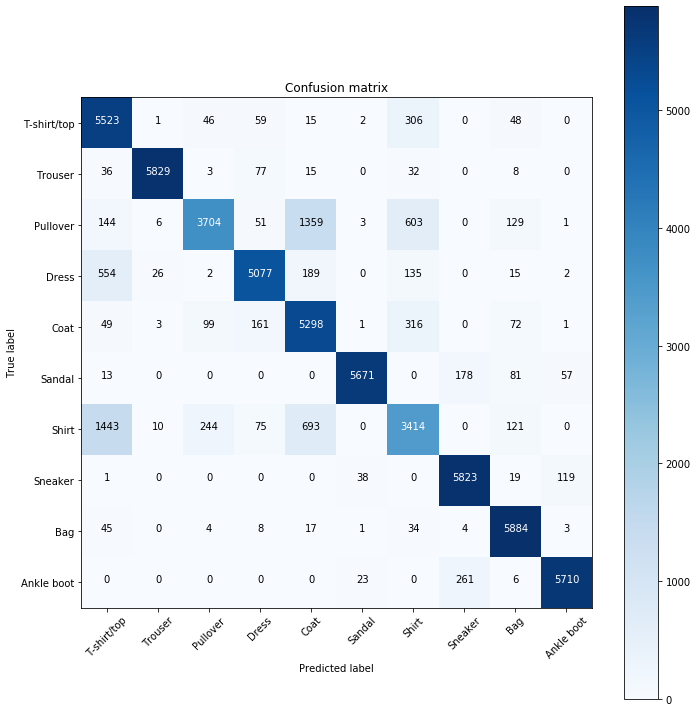

In [86]:
names = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

The confusion matrix has three axes:
- Prediction label (class)
- True label
- Heat map value (color)  

The prediction label and true labels show us which prediction class we are dealing with. The matrix diagonal represents locations in the matrix where the prediction and the truth are the same, so this is where we want the heat map to be darker.

Any values that are not on the diagonal are incorrect predictions because the prediction and the true label don't match. To read the plot, we can use these steps:
1. Choose a prediction label on the horizontal axis.
2. Check the diagonal location for this label to see the total number correct.
3. Check the other non-diagonal locations to see where the network is confused.

For example, the network is confusing a T-shirt/top with a shirt, but is not confusing the T-shirt/top with things like: Ankle boot, Sneaker, Sandal.
If we think about it, this makes pretty good sense. As our model learns, we will see the numbers that lie outside the diagonal become smaller and smaller.


##### Analyse training loop by using TensorBoard with PyTorch 

[Tensorboard](https://www.tensorflow.org/tensorboard/) provides visualization and tooling needed for machine learning experimentation. With tensorboard, we can:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling TensorFlow programs
- And much more

It is a font-end web interface that essentially reads data from a file and displays it. PyTorch has created a utility class called `SummaryWriter` which will help us get the data out of our program, save on disk so as to tensorboard can read.   
To use tensorboard, PyTorch version 1.1.0 is required.

In [24]:
import torch
print(f" torch version: {torch.__version__}")

 torch version: 1.4.0


In [ ]:
!pip install tensorboard==1.15.0;
from torch.utils.tensorboard import SummaryWriter

The SummaryWriter class comes with a bunch of method that we can call to selectively pick and choose which data we want to be available to TensorBoard. We will add 4 types of data to tensorboard for visualization:
1. images
2. graph
3. scalar value
4. histogram

These added values are even updated and showed in real-time on tensorboard as the network trains.

It is helpful to see the loss and accuracy values over time. However, the real power of TensorBoard is its out-of-the-box capability of comparing multiple runs. This allows us to rapidly experiment by varying the hyperparameter values and comparing runs to see which parameters are working best.

One more thing to be notices, with PyTorch's SummaryWriter a run starts when the writer object instance is created and ends when the writer instance is closed or goes out of scope.


In [29]:
model = Network()
train_dl = torch.utils.data.DataLoader(train_set, batch_size=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
accuracy = lambda preds, lbs: (F.softmax(preds).argmax(dim=1) == lbs).sum().item()

imgs, lbls = next(iter(train_dl))    
grid = torchvision.utils.make_grid(imgs)

tb = SummaryWriter()
tb.add_image('image', grid) #1. Add a batch of images to the writer
tb.add_graph(model, imgs)   #2. Add graph of our model to the writer

for epoch in range(3):
    total_loss = 0
    total_acc  = 0
    
    for batch in train_dl:
        imgs, lbls = batch
        preds = model(imgs)
        loss = F.cross_entropy(preds, lbls)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss
        total_acc += accuracy(preds, lbls)
    
    nr_batch = len(train_set)
    #3. Add scalar values, average loss and average accuracy, to display on tensorboard over time or over epoch.
    tb.add_scalar('Average_Loss', total_loss/nr_batch, epoch) 
    tb.add_scalar('Average_Accuracy', total_acc/nr_batch, epoch)
    
    #4. Add values to histograms to see its frequency distributions.
    tb.add_histogram('conv1.bias', model.conv1.bias, epoch)
    tb.add_histogram('conv1.weight', model.conv1.weight, epoch)
    tb.add_histogram('conv1.weight.grad', model.conv1.weight.grad, epoch)
    
    print(f"epoch:       {epoch} \navg_loss: {total_loss/nr_batch} \navg_acc : {total_acc/nr_batch}")

tb.close()


/Users/phucnsp/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


epoch:       0 
avg_loss: 0.06133313849568367 
avg_acc : 0.7699666666666667
epoch:       1 
avg_loss: 0.05296260863542557 
avg_acc : 0.80595
epoch:       2 
avg_loss: 0.051954615861177444 
avg_acc : 0.8122833333333334


By default, the PyTorch SummaryWriter object writes the data to disk in a directory called `./runs` that is created in the current working directory.
To launch TensorBoard, we have 2 ways:
1. run and show directly on jupyter notebook 
2. run the tensorboard command at our terminal and open `http://localhost:6006` on browser.    

To be noticed, the defaut save path and open port are able to change if you want.


In [96]:
# 1. run and show directly on jupyter notebook 
%load_ext tensorboard
%tensorboard --logdir=runs --port=6006


In [16]:
# 2. run the tensorboard command at our terminal and open `http://localhost:6006` on browser.
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
TensorBoard 1.15.0 at http://VN0130.local:6006/ (Press CTRL+C to quit)
^C


##### Hyperparameter Experimenting - Training Neural Networks

The best part about TensorBoard is its out-of-the-box capability of tracking our hyperparameters over time and across runs. We can use TensorBoard to rapidly experiment with different training hyperparameters comparing the results.

To uniquely identify each run, we can either set the file name of the run directly, or pass a comment string to the constructor that will be appended to the auto-generated file name.

Note the `cross_entropy` function with `reduction=mean` has averaged the loss over batch size and our `total_loss` is then summed up. It is correct if we have a fix batch size and its value is divisible by number of sample (if not, last batch will has less sample than others). However, in the case of batch size vary, we have to change `reduction=sum`.

If we have a list of parameters, we can package them up into a set for each of our runs using the Cartesian product. The Cartesian product takes multiple sets as arguments and return a set of all ordered pairs. Note that this is equivalent to nested for-loops.


In [32]:
from itertools import product # itertools' Cartesian product implementation

# define the list of parameters and their value list that we want to tolerate
parameters = dict(
    lr = [0.1, 0.01],
    batch_size = [10, 100],
)
param_values = [v for v in parameters.values()]
# use the Cartesian product to iterate over the pairs of parameters'values 
for lr, batch_size in product(*param_values):
    print(lr, batch_size)
    

0.1 10
0.1 100
0.01 10
0.01 100


In [35]:
accuracy = lambda preds, lbs: (F.softmax(preds).argmax(dim=1) == lbs).sum().item()
model = Network()

for lr, batch_size in product(*param_values):        
    train_dl = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    imgs, lbls = next(iter(train_dl))
    grid = torchvision.utils.make_grid(imgs)

    comment = f" batch_size = {batch_size}, lr = {lr}"
    tb = SummaryWriter(comment=comment)
    tb.add_image('images', grid)
    tb.add_graph(model, imgs)

    for epoch in range(3):
        total_loss = 0
        total_acc  = 0
        for batch in train_dl:
            imgs, lbls = batch
            preds = model(imgs)
            loss  = F.cross_entropy(preds, lbls, reduction='sum') 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc  += accuracy(preds, lbls)

        tb.add_scalar('average_loss', total_loss/len(train_set), epoch)
        tb.add_scalar('average_acc', total_acc/len(train_set), epoch)

        for name,param in model.named_parameters():
            tb.add_histogram(name, param, epoch)
            tb.add_histogram(f"{name}.grad", param.grad, epoch)

        print(f"epoch:       {epoch} \navg_loss: {total_loss/len(train_set)} \navg_acc : {total_acc/len(train_set)}")

    tb.close()
                

/Users/phucnsp/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


epoch:       0 
avg_loss: 2.3510418080329893 
avg_acc : 0.10213333333333334
epoch:       1 
avg_loss: 2.3241496319452923 
avg_acc : 0.10206666666666667
epoch:       2 
avg_loss: 2.3241496464411417 
avg_acc : 0.10208333333333333
epoch:       0 
avg_loss: 2.31076997756958 
avg_acc : 0.09978333333333333
epoch:       1 
avg_loss: 2.3104461242675782 
avg_acc : 0.0994
epoch:       2 
avg_loss: 2.3104453076680502 
avg_acc : 0.09963333333333334
epoch:       0 
avg_loss: 2.3050063188870746 
avg_acc : 0.10093333333333333
epoch:       1 
avg_loss: 2.3049483956654866 
avg_acc : 0.1014
epoch:       2 
avg_loss: 2.3049483927408856 
avg_acc : 0.1014
epoch:       0 
avg_loss: 2.3035935297648114 
avg_acc : 0.10016666666666667
epoch:       1 
avg_loss: 2.303564562733968 
avg_acc : 0.09968333333333333
epoch:       2 
avg_loss: 2.303563890838623 
avg_acc : 0.09968333333333333


In [36]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.
TensorBoard 1.15.0 at http://VN0130.local:6007/ (Press CTRL+C to quit)
^C


We can refactor the way we manage parameters by using the following `RunBuilder` Class. The method `get_runs()` will get the runs for us that it builds based on the parameters we pass in.

In [44]:
from collections import OrderedDict
from collections import namedtuple
from itertools import product

class RunBuilder():
    @staticmethod
    def get_runs(params):
        # create new tuple subclass called Run with named fields got from params.keys
        Run = namedtuple('Run', params.keys())  
        runs = []
        # use Cartesian product to pair parameters'values and pass to Run.
        for v in product(*params.values()):
            runs.append(Run(*v))
        return runs

params = OrderedDict(
            lr = [.01, .001],
            batch_size = [10, 100]
)

runs = RunBuilder.get_runs(params)
runs

[Run(lr=0.01, batch_size=10),
 Run(lr=0.01, batch_size=100),
 Run(lr=0.001, batch_size=10),
 Run(lr=0.001, batch_size=100)]

We can see that the `RunBuilder` class has built and returned a list of four runs. Each of these runs has a learning rate and a batch size that defines the run.  
Notice the string representation of the run output. This string representation was automatically generated for us by the Run tuple class, and this string can be used to uniquely identify the run if we want to write out run statistics to disk for TensorBoard or any other visualization program.  
Additionally, because the run is object is a tuple with named attributes, we can access the values using dot notation like so:

In [45]:
run = runs[0]
run.lr, run.batch_size

(0.01, 10)

All we have to do to add additional values is to add them to the original parameter list, and if we want to add an additional type of parameter, all we have to do is add it. The new parameter and its values will automatically become available to be consumed inside the run. The string output for the run also updates as well.

This functionality will allow us to have greater control as we experiment with different values during training.


In [ ]:
accuracy = lambda preds, lbs: (F.softmax(preds).argmax(dim=1) == lbs).sum().item()
model = Network()

# for lr, batch_size in product(*param_values):                                  # old code
for run in RunBuilder.get_runs(params):                                          # Changes for RunBuilder
    train_dl = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size) # Changes for RunBuilder
    optimizer = torch.optim.Adam(model.parameters(), lr=run.lr)                  # Changes for RunBuilder

    imgs, lbls = next(iter(train_dl))
    grid = torchvision.utils.make_grid(imgs)

#     comment = f" batch_size = {batch_size}, lr = {lr}"                          # old code
    comment = f'-{run}'                                                           # Changes for RunBuilder
    tb = SummaryWriter(comment=comment)
    tb.add_image('images', grid)
    tb.add_graph(model, imgs)

    for epoch in range(3):
        total_loss = 0
        total_acc  = 0
        for batch in train_dl:
            imgs, lbls = batch
            preds = model(imgs)
            loss  = F.cross_entropy(preds, lbls, reduction='sum') 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc  += accuracy(preds, lbls)

        tb.add_scalar('average_loss', total_loss/len(train_set), epoch)
        tb.add_scalar('average_acc', total_acc/len(train_set), epoch)

        for name,param in model.named_parameters():
            tb.add_histogram(name, param, epoch)
            tb.add_histogram(f"{name}.grad", param.grad, epoch)

        print(f"epoch:       {epoch} \navg_loss: {total_loss/len(train_set)} \navg_acc : {total_acc/len(train_set)}")

    tb.close()
                

##### Speeding up the training process by increasing num_workers

To speed up the training process, we will make use of the `num_workers` optional attribute of the `DataLoader` class. By setting this number to `1`, default set to `0`, the speep can increase up to 20% and does not improve more or even worse with setting more than 1.  

The num_workers attribute tells the data loader instance how many sub-processes to use for data loading. By default, the num_workers value is set to zero, the training process will work sequentially inside the main process. After a batch is used during the training process and another one is needed, we read the batch data from disk.    
Now, if we have a worker process, we can make use of the fact that our machine has multiple cores. This means that the next batch can already be loaded and ready to go by the time the main process is ready for another batch. This is where the speed up comes from.   
If we add more batches to the queue doesn't mean the batches are being processes faster because we are bounded by the time it takes to forward and backward propagate a given batch.


## Random topics

### Neural net layer parameters

#### Parameter Vs Argument
Parameters are used in function definitions as place-holders while arguments are the actual values that are passed to the function. The parameters can be thought of as local variables that live inside a function.  
In our network's case, the names are the parameters and the values that we have specified are the arguments.

#### Types Of Parameters: 
A lot of terms in deep learning are used loosely, and the word parameter is one of them. The goal of these particular categories is to help us remember how each parameter's value is decided.

- Hyperparameters:
    - hyperparameters are parameters whose values are picked arbitrarily. The hyperparameters are used to construct our network’s architecture and are mainly chosen based on trial and error.
    - Convolutional layers have three parameters: `in_channels`, `out_channels`, `kernel_size`.
    - Linear layers have 2 parameters: `in_features`, `out_features`.
    - All of these parameters impact the network's architecture. Specifically, these parameters directly impact the weight tensors inside the layers. 
- Data dependent hyperparameters.
    - Data dependent hyperparameters are parameters whose values are dependent on data.
    - Some candidates from network above are:
        - `in_channels` parameter of the conv layer: depend on the number of channels of previous layer.
        - `in_features` parameter of the linear layer: depend on the data coming from previous layer. 
        - `out_features` parameter of the output layer: depend on the number of classes of our training set. 

- Learnable Parameters
    - Learnable parameters are parameters whose values are learned during the training process.
    - With learnable parameters, we typically start out with a set of arbitrary values, and these values then get updated in an iterative fashion as the network learns. Appropriate values are values that minimize the loss function.
    - The learnable parameters are the weights inside our network, and they live inside each layer.

### Stack vs Concat 
Concatenating joins a sequence of tensors along an existing axis, and stacking joins a sequence of tensors along a new axis.


In [61]:
import torch

t1 = torch.tensor([1,1,1])
t2 = torch.tensor([2,2,2])
t3 = torch.tensor([3,3,3])

In [63]:
# Now, let’s concatenate these with one another. Notice that each of these tensors have a single axis. This 
# means that the result of the cat function will also have a single axis. This is because when we concatenate, 
# we do it along an existing axis. Notice that in this example, the only existing axis is the first axis.
# Alright, so we took three single axis tensors each having an axis length of three, and now we have a single 
# tensor with an axis length of nine.

torch.cat((t1,t2,t3),dim=0).shape

torch.Size([9])

In [65]:
# Now, let’s stack these tensors along a new axis that we’ll insert. We’ll insert an axis at the first index. 
# Note that this insertion will be happening implicitly under the hood by the stack function.
# This gives us a new tensor that has a shape of 3 x 3. Notice how the three tensors are concatenated along 
# the first axis of this tensor. Note that we can also insert the new axis explicitly, and preform the 
# concatenation directly.

torch.stack((t1,t2,t3), dim=0).shape

torch.Size([3, 3])

In [66]:
# example of combining stack and concat
# Joining Images With An Existing Batch
# Suppose we have the same three separate image tensors. Only, this time, we already have a batch tensor. 
# Assume our task is to join these three separate images with the batch.
import torch
batch = torch.zeros(3,3,28,28)
t1 = torch.zeros(3,28,28)
t2 = torch.zeros(3,28,28)
t3 = torch.zeros(3,28,28)

torch.cat(
    (
        batch
        ,torch.stack(
            (t1,t2,t3)
            ,dim=0
        )
    )
    ,dim=0
).shape

In [70]:
# Joining Batches Into A Single Batch
import torch
t1 = torch.zeros(1,3,28,28)
t2 = torch.zeros(1,3,28,28)
t3 = torch.zeros(1,3,28,28)
torch.cat(
    (t1,t2,t3)
    ,dim=0
).shape

torch.Size([3, 3, 28, 28])

In [71]:
# Joining Images Into A Single Batch
import torch
t1 = torch.zeros(3,28,28)
t2 = torch.zeros(3,28,28)
t3 = torch.zeros(3,28,28)

torch.stack(
    (t1,t2,t3)
    ,dim=0
).shape

torch.Size([3, 3, 28, 28])

### How many types of number of DL?

In deep learning, there are 2 types of numbers: `parameters` and `activation`.  
**Parameters** are numbers that are learned.  **Activations** are numbers that are calculated (by affine functions & element-wise non-linearities).
The hidden state is actuall a set of activation.

## Reference

Some good sources:
- [pytorch zero to all](https://github.com/hunkim/PyTorchZeroToAll)
- [deeplizard](https://deeplizard.com/learn/video/v5cngxo4mIg)
- [effective pytorch](https://github.com/vahidk/EffectivePyTorch?fbclid=IwAR1MhsjnjccWy6dIVtibFOCZbWhLtAj5pSTobnkUDxw_gHgfEswnVzqrKQ0#torchscript)
- [what is torch.nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)
- [recommend walk with pytorch](https://forums.fast.ai/t/getting-comfortable-with-pytorch-projects/28371)
- [official tutorial](https://pytorch.org/tutorials/)
- [DL(with Pytorch)](https://github.com/Atcold/pytorch-Deep-Learning)
- [Pytorch project template](https://github.com/moemen95/PyTorch-Project-Template)
- [nlp turorial with pytorch](https://github.com/graykode/nlp-tutorial)
- [UDACITY course](https://www.udacity.com/course/deep-learning-pytorch--ud188)
- [awesome pytorch list](https://github.com/bharathgs/Awesome-pytorch-list)
- [deep learning with pytorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf)
- others:
    - https://medium.com/pytorch/get-started-with-pytorch-cloud-tpus-and-colab-a24757b8f7fc
    - Grokking Algorithms: An illustrated guide for programmers and other curious people 1st Edition